In [ ]:
#| hide

# This cell will not be rendered but is to hide warnings and limit the rows shown

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

import pandas as pd
pd.set_option('display.max_rows', 6)

# TSB Model

> Step-by-step guide on using the `TSB Model` with `Statsforecast`.

During this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation` in other.

## Table of Contents

* [Introduction](#introduction)
* [TSB](#model)
* [Loading libraries and data](#loading)
* [Explore data with the plot method](#plotting)
* [Split the data into training and testing](#splitting)
* [Implementation of TSB with StatsForecast](#implementation)
* [Cross-validation](#cross_validate)
* [Model evaluation](#evaluate)
* [References](#references)

## Introduction <a class="anchor" id="introduction"></a>

The Teunter-Syntetos-Babai (TSB) model is a model used in the field of inventory management and demand forecasting in time series. It was proposed by Teunter, Syntetos, and Babai in 2001 as an extension of Croston's demand forecasting model.

The TSB model is specifically used to forecast demand for products with intermittent demand characteristics, that is, products that experience periods of demand followed by periods of non-demand. It is designed to handle time series data with many zeros and variability in the intervals between non-null observations.

The TSB model is based on two main components: the level model and the interval model. The level model estimates the level of demand when it occurs, while the interval model estimates the interval between demand occurrences. These two components combine to generate accurate forecasts of future demand.

The TSB model has proven to be effective in intermittent demand forecasting and has been widely used in various industrial sectors. However, it is important to note that there are other models and approaches available for demand forecasting, and the choice of the appropriate model will depend on the specific characteristics of the data and the context in which it is applied.

## TSB Model<a class="anchor" id="model"></a>

TSB (Teunter, Syntetos and Babai) is a new method proposed in 2011, the method replace the demand interval by demand probability which is updated every period. The reason for this is the Croston’s method only update demand when it occur, however in real life there are plenty of cases with many zero demands, therefore, the result of forecast will be unsuitable for estimating the risk of obsolescence because of the outdated information.

In TSB method, the $D_t$  represent the demand occurrence indicator for period $t$, so :

If $D_t=0$, then 

$$Z'_t=Z'_{t-1}$$

$$D_t=D'_{t-1}+\beta (0- D'_{t-1})$$

Otherwise
$$Z'_t=Z'_{t-1}+\alpha(Z_t - Z'_{t-2})$$

$$D'_t=D'_{t-1}+\beta(1-D'_{t-1})$$

Hence, the forecast is given by

$$Y'_t=D'_t \cdot Z'_t$$

Where

- $Y'_t:$ Average demand per period
- $Z_t:$ Actual demand at period $t$
- $Z'_t:$ Time between two positive demand
- $D'_t:$ Estimate probability of a demand occurrence at the end of period $t$
- $\alpha, \beta:$ Smoothing Constant, $0 \leq \alpha, \beta \leq 1$




### TSB General Properties

The Teunter-Syntetos-Babai (TSB) model for time series has the following properties:

1. Intermittent Demand Modelling: The TSB model is specifically designed to forecast intermittent demand, which is characterized by periods of non-demand followed by periods of demand. The model efficiently addresses this characteristic of demand.

2. Level and interval components: The TSB model is based on two main components: the level model and the interval model. The level model estimates the level of demand when it occurs, while the interval model estimates the interval between demand occurrences.

3. Handling data with many zeros: The TSB model can efficiently handle time series data with many zeros, which are common in intermittent demand. The model properly considers these zeros in the forecasting process.

4. Exponential Smoothing: The TSB model uses exponential smoothing methods to estimate demand levels and intervals between occurrences. Exponential smoothing is a widely used technique in time series forecasting.

5. Confidence interval estimation: The TSB model provides confidence interval estimates for the generated forecasts. This allows having a measure of the uncertainty associated with forecasts and facilitates decision making.

6. Simplicity and ease of implementation: The TSB model is relatively simple and easy to implement compared to other more complex approaches. It does not require sophisticated assumptions about the distribution of demand and can be applied in a practical way.

Those are some of the fundamental properties of the Teunter-Syntetos-Babai model in the context of time series and intermittent demand forecasting.

## Loading libraries and data <a class="anchor" id="loading"></a>

:::{.callout-tip} Statsforecast will be needed. To install, see [instructions](../getting-started/Installation.ipynb). :::

Next, we import plotting libraries and configure the plotting style.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('grayscale') # fivethirtyeight  grayscale  classic
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#008080',  # #212946
    'axes.facecolor': '#008080',
    'savefig.facecolor': '#008080',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#000000',  #2A3459
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)


from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

In [ ]:
import pandas as pd

df=pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/intermittend_demand2")
df.head()

,date,sales
0,2022-01-01 00:00:00,0
1,2022-01-01 01:00:00,10
2,2022-01-01 02:00:00,0
3,2022-01-01 03:00:00,0
4,2022-01-01 04:00:00,100


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [ ]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,2022-01-01 00:00:00,0,1
1,2022-01-01 01:00:00,10,1
2,2022-01-01 02:00:00,0,1
3,2022-01-01 03:00:00,0,1
4,2022-01-01 04:00:00,100,1


In [ ]:
print(df.dtypes)

ds           object
y             int64
unique_id    object
dtype: object


We can see that our time variable `(ds)` is in an object format, we need to convert to a date format

In [ ]:
df["ds"] = pd.to_datetime(df["ds"])

## Explore Data with the plot method <a class="anchor" id="plotting"></a>

Plot some series using the plot method from the StatsForecast class. This method prints a random series from the dataset and is useful for basic EDA.

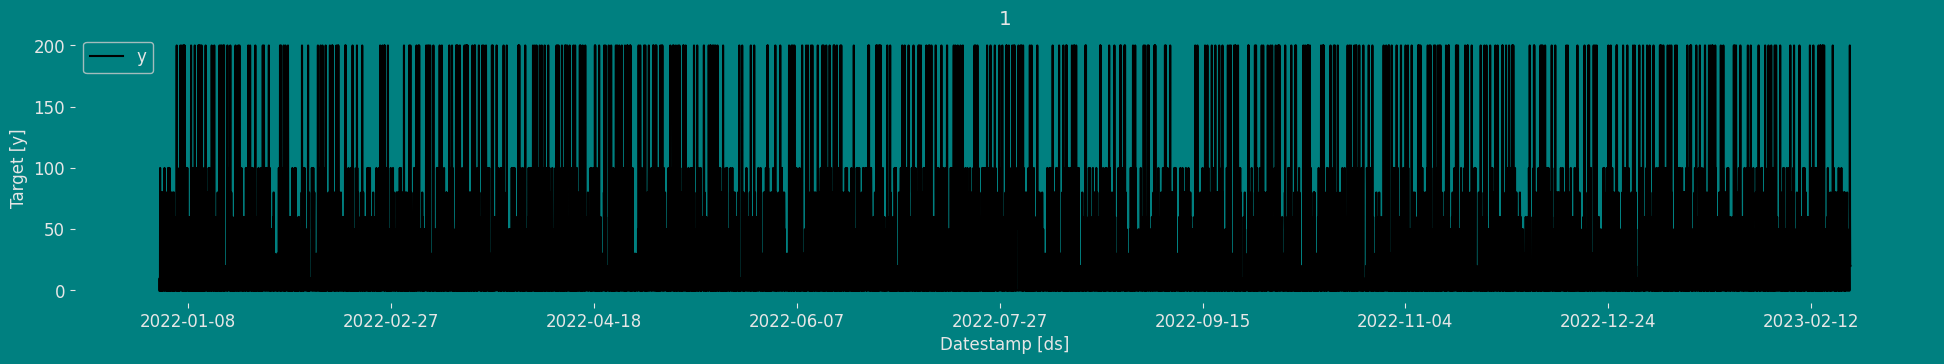

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

### Autocorrelation plots

Autocorrelation (ACF) and partial autocorrelation (PACF) plots are statistical tools used to analyze time series. ACF charts show the correlation between the values of a time series and their lagged values, while PACF charts show the correlation between the values of a time series and their lagged values, after the effect of previous lagged values has been removed.

ACF and PACF charts can be used to identify the structure of a time series, which can be helpful in choosing a suitable model for the time series. For example, if the ACF chart shows a repeating peak and valley pattern, this indicates that the time series is stationary, meaning that it has the same statistical properties over time. If the PACF chart shows a pattern of rapidly decreasing spikes, this indicates that the time series is invertible, meaning it can be reversed to get a stationary time series.

The importance of the ACF and PACF charts is that they can help analysts better understand the structure of a time series. This understanding can be helpful in choosing a suitable model for the time series, which can improve the ability to predict future values of the time series.

To analyze ACF and PACF charts:

* Look for patterns in charts. Common patterns include repeating peaks and valleys, sawtooth patterns, and plateau patterns.
* Compare ACF and PACF charts. The PACF chart generally has fewer spikes than the ACF chart.
* Consider the length of the time series. ACF and PACF charts for longer time series will have more spikes.
* Use a confidence interval. The ACF and PACF plots also show confidence intervals for the autocorrelation values. If an autocorrelation value is outside the confidence interval, it is likely to be significant.

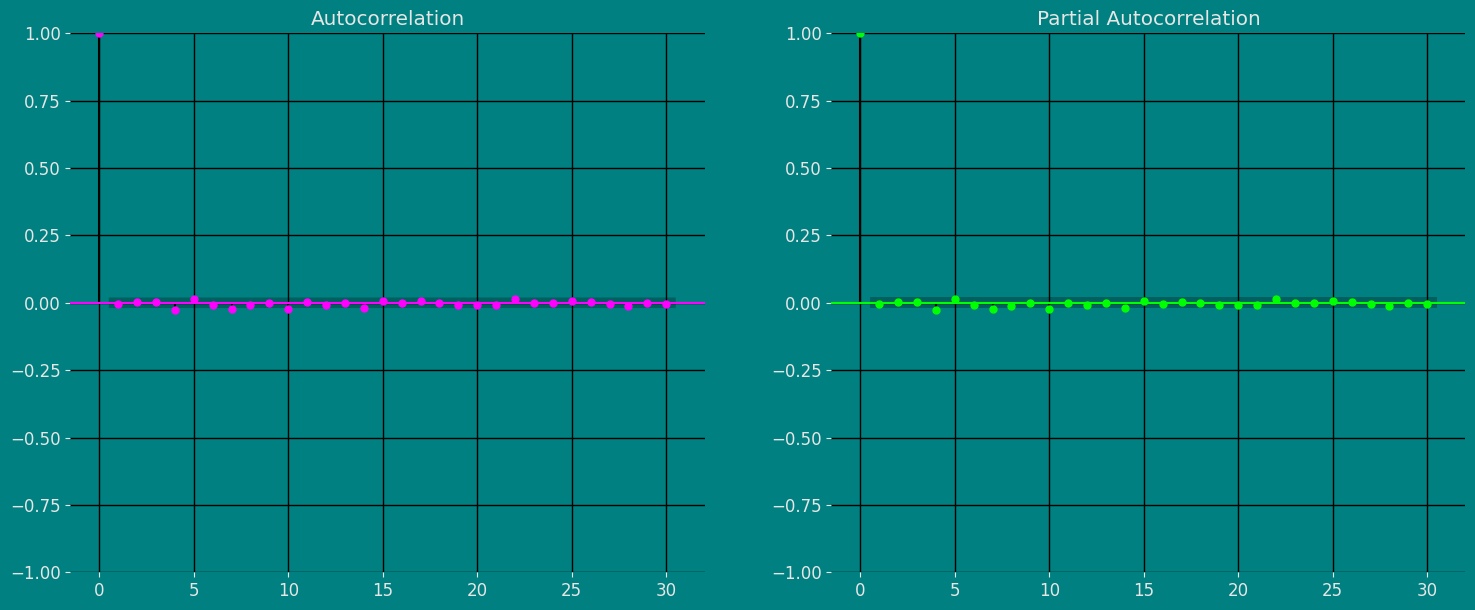

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

### Decomposition of the time series

How to decompose a time series and why?

In time series analysis to forecast new values, it is very important to know past data. More formally, we can say that it is very important to know the patterns that values follow over time. There can be many reasons that cause our forecast values to fall in the wrong direction. Basically, a time series consists of four components. The variation of those components causes the change in the pattern of the time series. These components are:

* **Level:** This is the primary value that averages over time.
* **Trend:** The trend is the value that causes increasing or decreasing patterns in a time series.
* **Seasonality:** This is a cyclical event that occurs in a time series for a short time and causes short-term increasing or decreasing patterns in a time series.
* **Residual/Noise:** These are the random variations in the time series.

Combining these components over time leads to the formation of a time series. Most time series consist of level and noise/residual and trend or seasonality are optional values.

If seasonality and trend are part of the time series, then there will be effects on the forecast value. As the pattern of the forecasted time series may be different from the previous time series.

The combination of the components in time series can be of two types:
* Additive
* Multiplicative

### Additive time series

If the components of the time series are added to make the time series. Then the time series is called the additive time series. By visualization, we can say that the time series is additive if the increasing or decreasing pattern of the time series is similar throughout the series. The mathematical function of any additive time series can be represented by:
$$y(t) = level + Trend + seasonality + noise$$

### Multiplicative time series

If the components of the time series are multiplicative together, then the time series is called a multiplicative time series. For visualization, if the time series is having exponential growth or decline with time, then the time series can be considered as the multiplicative time series. The mathematical function of the multiplicative time series can be represented as.

$$y(t) = Level * Trend * seasonality * Noise$$

In [ ]:
from plotly.subplots import make_subplots

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plotSeasonalDecompose(
    x,
    model='additive',
    filt=None,
    period=None,
    two_sided=True,
    extrapolate_trend=0,
    title="Seasonal Decomposition"):

    result = seasonal_decompose(
            x, model=model, filt=filt, period=period,
            two_sided=two_sided, extrapolate_trend=extrapolate_trend)
    fig = make_subplots(
            rows=4, cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"])
    for idx, col in enumerate(['observed', 'trend', 'seasonal', 'resid']):
        fig.add_trace(
            go.Scatter(x=result.observed.index, y=getattr(result, col), mode='lines'),
                row=idx+1, col=1,
            )
    return fig

In [ ]:
plotSeasonalDecompose(
    df["y"],
    model="additive",
    period=24,
    title="Seasonal Decomposition")

## Split the data into training and testing<a class="anchor" id="splitting"></a>

Let's divide our data into sets
1. Data to train our `TSB Model`.
2. Data to test our model

For the test data we will use the last 500 Hours to test and evaluate the performance of our model.

In [ ]:
train = df[df.ds<='2023-01-31 19:00:00'] 
test = df[df.ds>'2023-01-31 19:00:00'] 

In [ ]:
train.shape, test.shape

((9500, 3), (500, 3))

Now let's plot the training data and the test data.

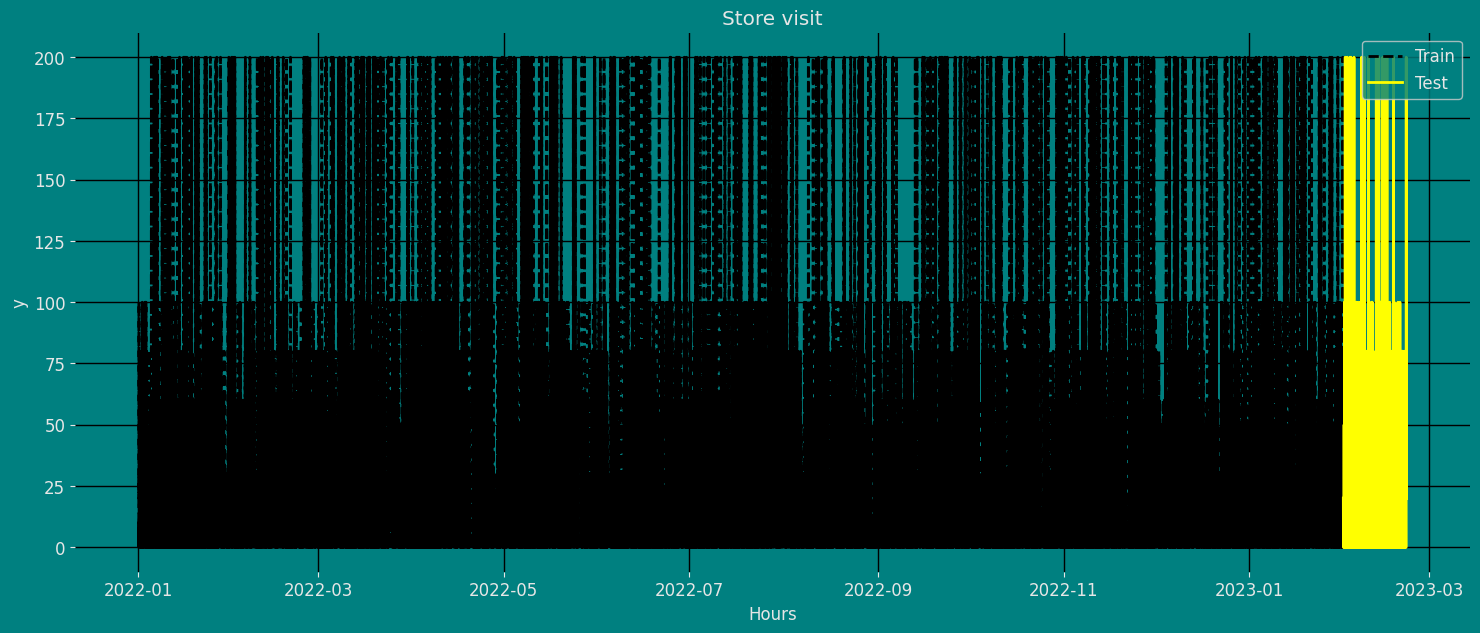

In [ ]:
sns.lineplot(train,x="ds", y="y", label="Train", linestyle="--",linewidth=2)
sns.lineplot(test, x="ds", y="y", label="Test", linewidth=2, color="yellow")
plt.title("Store visit");
plt.xlabel("Hours")
plt.show()

## Implementation of `TSB Model` with StatsForecast<a class="anchor" id="implementation"></a>

To also know more about the parameters of the functions of the `TSB Model` you can see it [here](https://nixtla.github.io/statsforecast/src/core/models.html#tsb).

```
alpha_d : float
    Smoothing parameter for demand.
alpha_p : float
    Smoothing parameter for probability.
alias : str
    Custom name of the model.
prediction_intervals : Optional[ConformalIntervals]
    Information to compute conformal prediction intervals.
    By default, the model will compute the native prediction
    intervals.
```

### Load libraries

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import TSB

### Building Model

Import and instantiate the models. Setting the argument is sometimes tricky. This article on [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/) by the master, Rob Hyndmann, can be useful for `season_length`.

In [ ]:
season_length = 24 # Hourly data 
horizon = len(test) # number of predictions

models = [TSB(alpha_d=0.8, alpha_p=0.9)]

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [pandas’ available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
sf = StatsForecast(df=df,
                   models=models,
                   freq='H', 
                   n_jobs=-1)

### Fit the Model

In [ ]:
sf.fit()

StatsForecast(models=[TSB])

Let's see the results of our `TSB Model`. We can observe it with the following instruction:

In [ ]:
result=sf.fitted_[0,0].model_
result

{'mean': array([22.443005], dtype=float32)}

### Forecast Method

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 500 hours ahead.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min.

In [ ]:
Y_hat = sf.forecast(horizon)
Y_hat

,ds,TSB
unique_id,,
1,2023-02-21 16:00:00,22.443005
1,2023-02-21 17:00:00,22.443005
1,2023-02-21 18:00:00,22.443005
...,...,...
1,2023-03-14 09:00:00,22.443005
1,2023-03-14 10:00:00,22.443005
1,2023-03-14 11:00:00,22.443005


In [ ]:
Y_hat=Y_hat.reset_index()
Y_hat

,unique_id,ds,TSB
0,1,2023-02-21 16:00:00,22.443005
1,1,2023-02-21 17:00:00,22.443005
2,1,2023-02-21 18:00:00,22.443005
...,...,...,...
497,1,2023-03-14 09:00:00,22.443005
498,1,2023-03-14 10:00:00,22.443005
499,1,2023-03-14 11:00:00,22.443005


In [ ]:
# Concat the forecasts with the true values
Y_hat1 = pd.concat([df,Y_hat])
Y_hat1

,ds,y,unique_id,TSB
0,2022-01-01 00:00:00,0.0,1,NaN
1,2022-01-01 01:00:00,10.0,1,NaN
2,2022-01-01 02:00:00,0.0,1,NaN
...,...,...,...,...
497,2023-03-14 09:00:00,NaN,1,22.443005
498,2023-03-14 10:00:00,NaN,1,22.443005
499,2023-03-14 11:00:00,NaN,1,22.443005


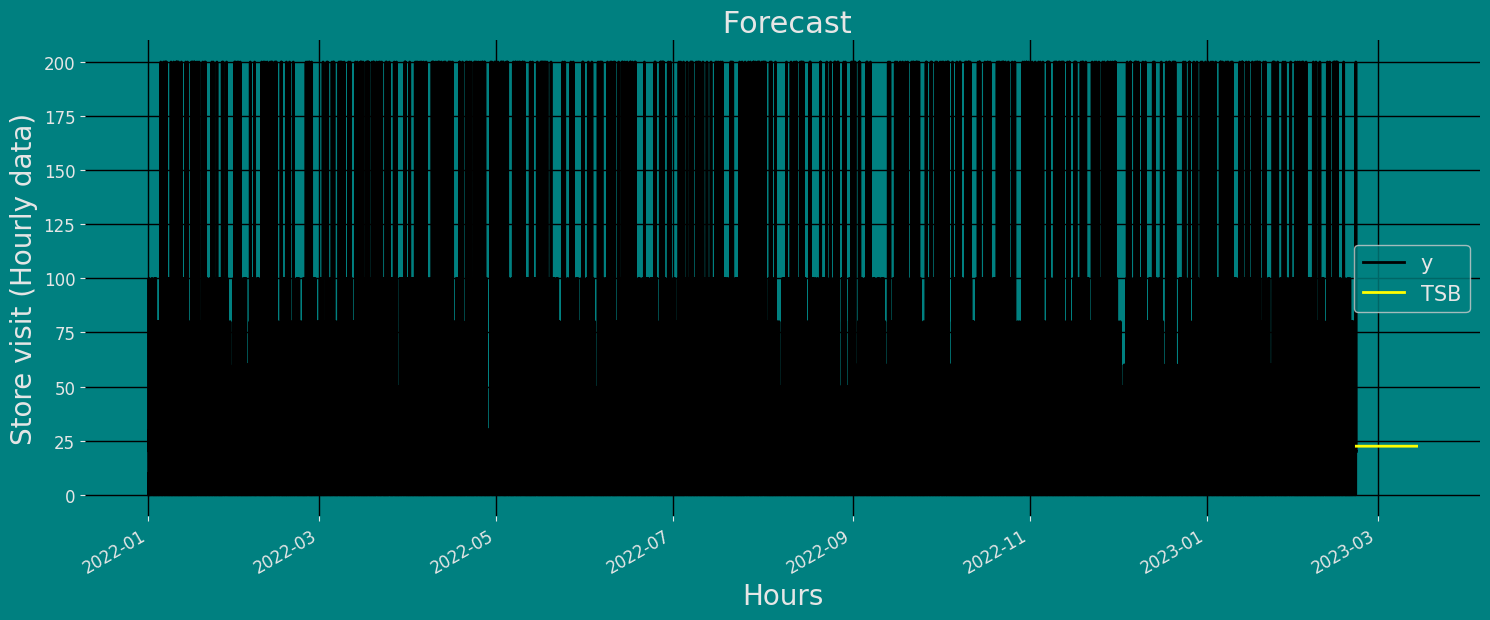

In [ ]:
fig, ax = plt.subplots(1, 1)
plot_df = pd.concat([df, Y_hat1]).set_index('ds')
plot_df['y'].plot(ax=ax, linewidth=2)
plot_df["TSB"].plot(ax=ax, linewidth=2, color="yellow")
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel("Store visit (Hourly data)", fontsize=20)
ax.set_xlabel('Hours', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid(True)

### Predict method with confidence interval

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 500 hours ahead.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [ ]:
forecast_df = sf.predict(h=horizon) 

forecast_df

,ds,TSB
unique_id,,
1,2023-02-21 16:00:00,22.443005
1,2023-02-21 17:00:00,22.443005
1,2023-02-21 18:00:00,22.443005
...,...,...
1,2023-03-14 09:00:00,22.443005
1,2023-03-14 10:00:00,22.443005
1,2023-03-14 11:00:00,22.443005


We can join the forecast result with the historical data using the pandas function `pd.concat()`, and then be able to use this result for graphing.

In [ ]:
pd.concat([df, forecast_df]).set_index('ds')

,y,unique_id,TSB
ds,,,
2022-01-01 00:00:00,0.0,1.0,NaN
2022-01-01 01:00:00,10.0,1.0,NaN
2022-01-01 02:00:00,0.0,1.0,NaN
...,...,...,...
2023-03-14 09:00:00,NaN,NaN,22.443005
2023-03-14 10:00:00,NaN,NaN,22.443005
2023-03-14 11:00:00,NaN,NaN,22.443005


In [ ]:
df_plot= pd.concat([df, forecast_df]).set_index('ds').tail(5000)
df_plot

,y,unique_id,TSB
ds,,,
2022-08-18 04:00:00,0.0,1.0,NaN
2022-08-18 05:00:00,80.0,1.0,NaN
2022-08-18 06:00:00,0.0,1.0,NaN
...,...,...,...
2023-03-14 09:00:00,NaN,NaN,22.443005
2023-03-14 10:00:00,NaN,NaN,22.443005
2023-03-14 11:00:00,NaN,NaN,22.443005


Now let's visualize the result of our forecast and the historical data of our time series.

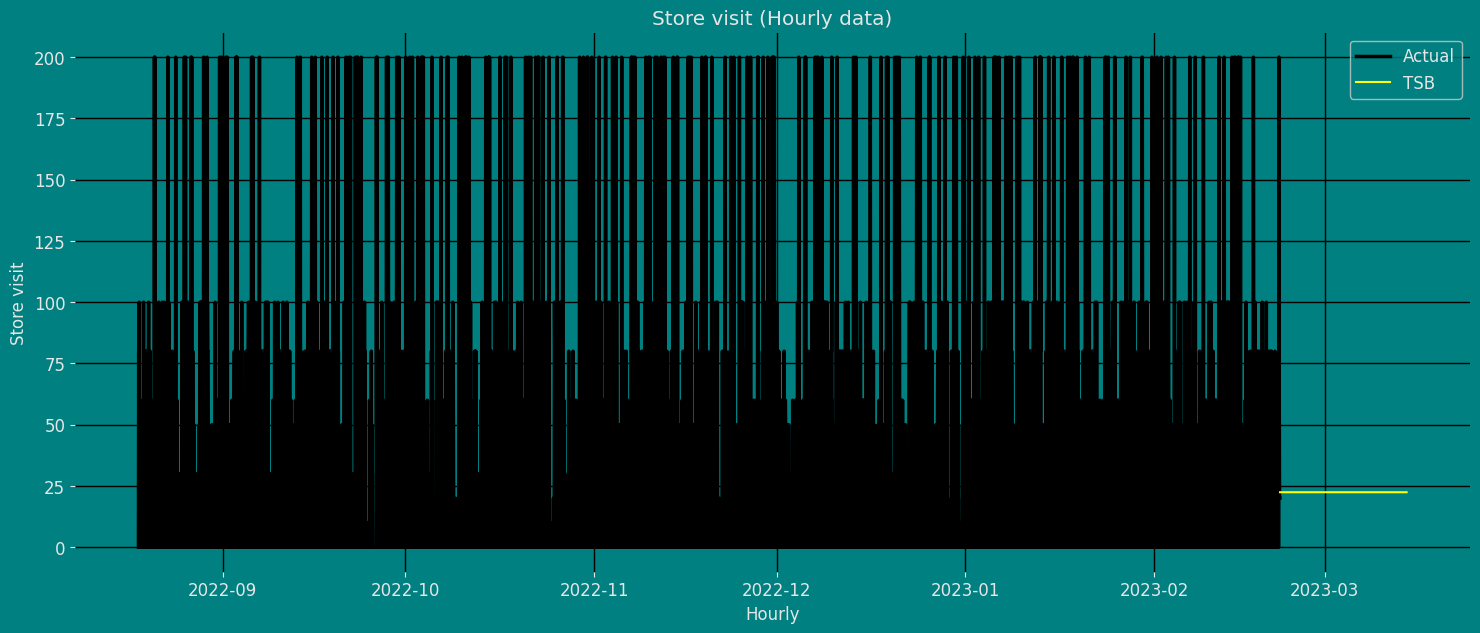

In [ ]:
plt.plot(df_plot['y'],label="Actual", linewidth=2.5)
plt.plot(df_plot['TSB'], label="TSB", color="yellow") # '-', '--', '-.', ':',

plt.title("Store visit (Hourly data)");
plt.xlabel("Hourly")
plt.ylabel("Store visit")
plt.legend()
plt.show();

Let's plot the same graph using the plot function that comes in `Statsforecast`, as shown below.

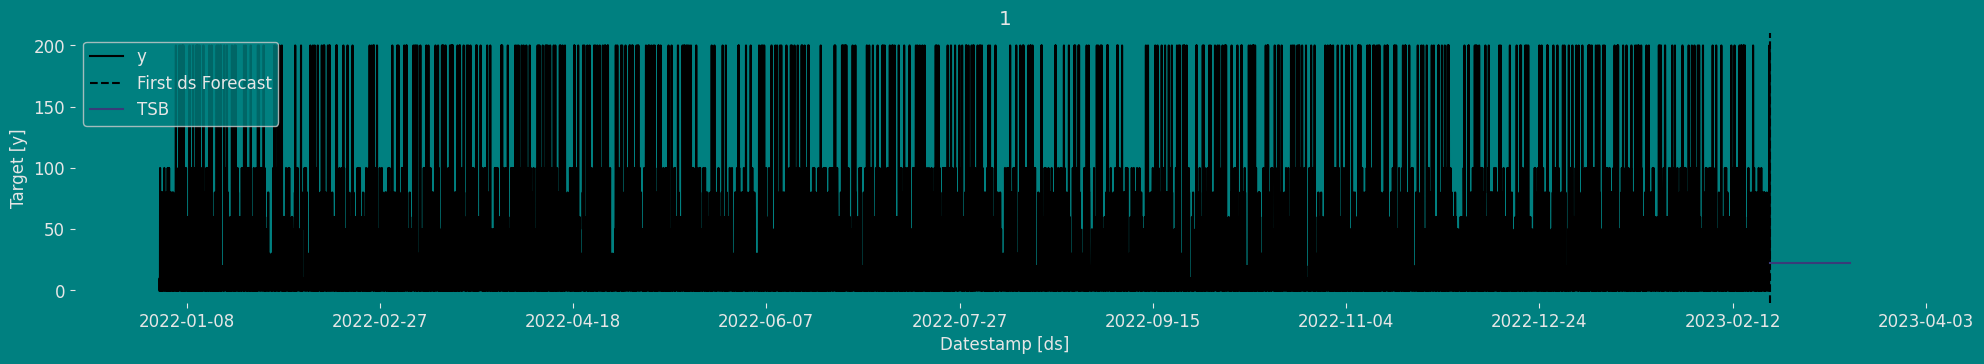

In [ ]:
sf.plot(df, forecast_df)

## Cross-validation <a class="anchor" id="cross_validate"></a>

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

### Perform time series cross-validation

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 5 months `(n_windows=)`, forecasting every second months `(step_size=50)`. Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 500 hours ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
crossvalidation_df = sf.cross_validation(df=df,
                                         h=horizon,
                                         step_size=50,
                                         n_windows=5)

The crossvaldation_df object is a new data frame that includes the following columns:

* `unique_id:` index. If you dont like working with index just run `crossvalidation_df.resetindex()`.
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the `n_windows`.
* `y:` true value
* `model:` columns with the model’s name and fitted value.

In [ ]:
crossvalidation_df

,ds,cutoff,y,TSB
unique_id,,,,
1,2023-01-23 12:00:00,2023-01-23 11:00:00,0.0,0.000005
1,2023-01-23 13:00:00,2023-01-23 11:00:00,0.0,0.000005
1,2023-01-23 14:00:00,2023-01-23 11:00:00,0.0,0.000005
...,...,...,...,...
1,2023-02-21 13:00:00,2023-01-31 19:00:00,60.0,65.586456
1,2023-02-21 14:00:00,2023-01-31 19:00:00,20.0,65.586456
1,2023-02-21 15:00:00,2023-01-31 19:00:00,20.0,65.586456


## Evaluate Model <a class="anchor" id="evaluate"></a>

We can now compute the accuracy of the forecast using an appropiate accuracy metric. Here we’ll use the Root Mean Squared Error (RMSE). To do this, we first need to `install datasetsforecast`, a Python library developed **by Nixtla** that includes a function to compute the RMSE.

In [ ]:
%%capture
!pip install datasetsforecast

In [ ]:
from datasetsforecast.losses import rmse

The function to compute the RMSE takes two arguments:

1. The actual values.
2. The forecasts, in this case, `TSB Model`.

In [ ]:
rmse = rmse(crossvalidation_df['y'], crossvalidation_df["TSB"])
print("RMSE using cross-validation: ", rmse)

RMSE using cross-validation:  91.88035


## References <a class="anchor" id="references"></a>

1. Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python. 
2. Ivan Svetunkov. [Forecasting and Analytics with the Augmented Dynamic Adaptive Model (ADAM)](https://openforecast.org/adam/)
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Nixtla Parameters](https://nixtla.github.io/statsforecast/src/core/models.html#arch-model).
5. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
6. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting principles and practice, Time series cross-validation”.](https://otexts.com/fpp3/tscv.html).
7. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).